# AI Query Tube

## 1. Setup and Imports

In [2]:
%pip install youtube-transcript-api sentence-transformers tf-keras

import os
import sys
import time
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from youtube_transcript_api import YouTubeTranscriptApi
from youtube_transcript_api._errors import TranscriptsDisabled, NoTranscriptFound, VideoUnavailable
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

Note: you may need to restart the kernel to use updated packages.


c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. YouTube Data Collection

In [3]:
API_KEY = os.environ.get('YOUTUBE_API_KEY')
if API_KEY is None:
    raise RuntimeError('Set YOUTUBE_API_KEY in the environment before running this notebook')
CHANNEL_ID = "UC4SVo0Ue36XCfOyb5Lh1viQ"

In [ ]:
url = "https://www.googleapis.com/youtube/v3/search"
params = {
    "key": API_KEY,
    "channelId": CHANNEL_ID,
    "part": "snippet,id",
    "order": "date",
    "maxResults": 50,
    "hl": "en",
    "regionCode": "US"
}

def extract_video_fields(item):
    video_id = item["id"]["videoId"]
    title = item["snippet"]["title"]
    published = item["snippet"]["publishedAt"]
    return video_id, title, published 

videos = []
next_page_token = None


# Set a limit of pages to fetch to avoid infinite loops if something goes wrong, or remove for full channel
max_pages = 10
page_count = 0

while True:
    if next_page_token:
        params['pageToken'] = next_page_token

    try:
        resp = requests.get(url, params=params, timeout=10)
        resp.raise_for_status()
        data = resp.json()
    except Exception as e:
        print('Request failed:', e)
        break

    for item in data.get("items", []):
        if "videoId" in item.get("id", {}):
            video_id, title, published = extract_video_fields(item)
            videos.append([video_id, title, published])

    next_page_token = data.get("nextPageToken")
    page_count += 1
    if not next_page_token or page_count >= max_pages:
        break

df = pd.DataFrame(videos, columns=["video_id", "title", "published_date"])
df.to_csv("youtube_metadata.csv", index=False)
display(df.head())

,video_id,title,published_date
0,fPopFeqw5sk,Learn NumPy data types in 8 minutes! 💱,2025-11-21T15:40:45Z
1,xf71dRBRP6o,Build a music player with Python! 🎶,2025-11-20T16:51:00Z
2,k0D3MQwLn7A,Learn Python iterators in 7 minutes! ➡️,2025-11-10T14:21:48Z
3,ZBlxaXMN_hU,Learn Python generator expressions in 9 minute...,2025-11-07T15:08:16Z
4,c9vhHUGdav0,Learn Matplotlib in 1 hour! 📊,2025-10-09T14:01:03Z


## 3. Exploratory Data Analysis (EDA)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   video_id        215 non-null    object
 1   title           215 non-null    object
 2   published_date  215 non-null    object
dtypes: object(3)
memory usage: 5.2+ KB


None

,video_id,title,published_date
count,215,215,215
unique,215,215,215
top,fPopFeqw5sk,Learn NumPy data types in 8 minutes! 💱,2025-11-21T15:40:45Z
freq,1,1,1


Missing values:
video_id          0
title             0
published_date    0
dtype: int64


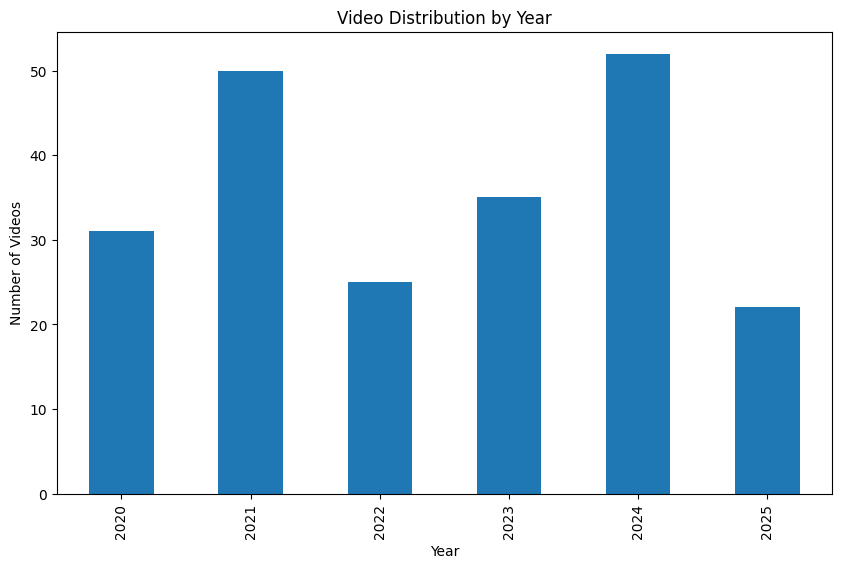

In [5]:
# Basic info
display(df.info())
display(df.describe())

# Missing values
print("Missing values:")
print(df.isnull().sum())

# Publish date distribution
df['published_date'] = pd.to_datetime(df['published_date'])
plt.figure(figsize=(10, 6))
df['published_date'].dt.year.value_counts().sort_index().plot(kind='bar')
plt.title('Video Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Number of Videos')
plt.show()

## 4. Transcript Fetching

In [ ]:

import pandas as pd
import time
from youtube_transcript_api import YouTubeTranscriptApi

# Load existing CSV (IMPORTANT)
df = pd.read_csv("youtube_metadata.csv")

# If transcript column doesn't exist, create it
if "transcript" not in df.columns:
    df["transcript"] = None

ytt_api = YouTubeTranscriptApi()
LIMIT = 10
DELAY = 1.0

# Fetch transcripts only for first 10 videos
for idx, vid in enumerate(df["video_id"].head(LIMIT)):
    try:
        transcript_object = ytt_api.fetch(vid)

        text = " ".join(
            snippet.text for snippet in transcript_object.snippets
        )

        # 🔥 Update ONLY that row
        df.loc[idx, "transcript"] = text
        print(f"✅ Success ({idx+1}/{LIMIT}): {vid}")

    except Exception as e:
        df.loc[idx, "transcript"] = None
        print(f"❌ Failed ({idx+1}/{LIMIT}): {vid} | {type(e).__name__}")

    time.sleep(DELAY)

# Save back to SAME file (safe overwrite)
df.to_csv("youtube_metadata.csv", index=False)

print("🎉 Transcript column updated for top 10 videos")

# Preview
df.head(12)


✅ Success (1/10): fPopFeqw5sk
✅ Success (2/10): xf71dRBRP6o
✅ Success (3/10): k0D3MQwLn7A
✅ Success (4/10): ZBlxaXMN_hU
✅ Success (5/10): c9vhHUGdav0
✅ Success (6/10): OUnnuKHbmbU
✅ Success (7/10): 6WaBryk4fkE
✅ Success (8/10): mjiHc965UME
✅ Success (9/10): sHrlK5tOGpw
✅ Success (10/10): tg5Wv9Ba1lI
🎉 Transcript column updated for top 10 videos


,video_id,title,published_date,transcript
0,fPopFeqw5sk,Learn NumPy data types in 8 minutes! 💱,2025-11-21T15:40:45Z,"Yo, hello again everybody. In this video, I'm ..."
1,xf71dRBRP6o,Build a music player with Python! 🎶,2025-11-20T16:51:00Z,"What is going on everybody? In this video, I t..."
2,k0D3MQwLn7A,Learn Python iterators in 7 minutes! ➡️,2025-11-10T14:21:48Z,"Hey, what is going on everybody? In this video..."
3,ZBlxaXMN_hU,Learn Python generator expressions in 9 minute...,2025-11-07T15:08:16Z,"All right, everybody. In this video, I'm going..."
4,c9vhHUGdav0,Learn Matplotlib in 1 hour! 📊,2025-10-09T14:01:03Z,"Hey everybody. In this video, I'm going to tea..."
5,OUnnuKHbmbU,DataFrames in Pandas are easy! 🔢,2025-09-04T14:00:37Z,"All right, let's do this everybody. We got to ..."
6,6WaBryk4fkE,Slicing in NumPy is easy! ✂️,2025-07-27T15:25:48Z,"Yo, hey everybody. In this video, I'm going to..."
7,mjiHc965UME,Convert decimal to hexadecimal EASY! #coding ...,2025-07-20T14:51:42Z,"Yo, hey everybody. In this video, I'm going to..."
8,sHrlK5tOGpw,Learn hexadecimal in 0x79 seconds #coding #com...,2025-07-16T14:10:13Z,"In this video, I'm going to show you how to ea..."
9,tg5Wv9Ba1lI,Learn binary in 01000000 seconds #coding #comp...,2025-07-13T15:43:58Z,Here's how to read binary numbers in roughly 6...


## 5. Embeddings and Search

In [ ]:
model = SentenceTransformer("all-MiniLM-L6-v2")

df["text_for_embedding"] = df["title"] + " " + df["transcript"].fillna("")
df["embedding"] = df["text_for_embedding"].apply(lambda x: model.encode(x))

c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [ ]:
query = "PHP tutorials"
query_embedding = model.encode(query)

scores = cosine_similarity([query_embedding], list(df["embedding"]))
top_idx = scores[0].argsort()[-5:][::-1]  # Top 5 results

results = df.iloc[top_idx][["title", "video_id"]].copy()
results["score"] = scores[0][top_idx]
display(results)

c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


,title,video_id,score
68,PHP tutorial for beginners 🐘,SI69DXbYHXU,0.740970
67,PHP $_GET and $_POST explained,6AzAYU8AOhQ,0.505770
69,PHP variables and data types,przRGJtl0HY,0.434665
51,MongoDB tutorial for beginners 🍃,6DoLxeMlVTI,0.431193
106,HTML tutorial for beginners 🌎,2oCN2q1x3c4,0.413551
